In [ ]:
from zipfile import ZipFile
import collections
import random
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import show, output_notebook
from bokeh.plotting import figure

from PIL import Image
import cv2
import skimage

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ReLU, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from skimage.transform import resize
from skimage.io import imread
from skimage.transform import rescale
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

# 1) Data Loading and Preliminary Observations

In [ ]:
# Get data and load to collab
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip # Train Images
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip # Test Images (no labels)
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip # Labels for test images

# Uncomment the below ONLY IF the above links do not work due to them being removed/problem with hosting site (doubtful, but backup below just in case)
# !wget -O GTSRB_Final_Training_Images.zip https://www.dropbox.com/s/5o01vx7ruqj5918/GTSRB_Final_Training_Images.zip?dl=0
# !wget -O GTSRB_Final_Test_Images.zip https://www.dropbox.com/s/k234pcurb6jhev8/GTSRB_Final_Test_Images.zip?dl=0
# !wget -O GTSRB_Final_Test_GT.zip https://www.dropbox.com/s/bz9viz6whergrjk/GTSRB_Final_Test_GT.zip?dl=0

train_file_name = 'GTSRB_Final_Training_Images.zip'
test_file_name = '/content/GTSRB_Final_Test_Images.zip'
test_labels_path = '/content/GTSRB_Final_Test_GT.zip'

with ZipFile(train_file_name, 'r') as zip1:
  zip1.extractall()

with ZipFile(test_file_name, 'r') as zip2:
  zip2.extractall()

with ZipFile(test_labels_path, 'r') as zip3:
  zip3.extractall()

--2022-04-24 09:13:45--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip.1’

GTSRB_Final_Trainin 100%[===================>] 263.50M  23.6MB/s    in 12s     

2022-04-24 09:13:58 (21.7 MB/s) - ‘GTSRB_Final_Training_Images.zip.1’ saved [276294756/276294756]

--2022-04-24 09:13:58--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88978620 (85M) [application/zip]
Saving to: ‘GTSRB_Final_Test_Images.zip.1’

GTSRB_Final_Test_Im 100%[===================>]

In [ ]:
# Train Data
main_train_dir = '/content/GTSRB/Final_Training/Images'
train_data = []
train_bounding_box = []
train_labels = []
train_file_name = []
train_folders = sorted(os.listdir(main_train_dir))

for folder in train_folders:
  csv_file = [x for x in os.listdir(os.path.join(main_train_dir,folder)) if x.endswith('.csv')]
  df = pd.read_csv(os.path.join(main_train_dir,folder, csv_file[0]), sep = ';')
  for file in os.listdir(os.path.join(main_train_dir, folder)):
    try:
      image = imread(os.path.join(main_train_dir, folder, file))
      bounding_boxes = df[df.Filename == file][['Roi.X1', 'Roi.X2', 'Roi.Y1', 'Roi.Y2']].to_dict('records') # get bounding box for each image, to be used later in preprocessing
      bounding_boxes = {k: v for d in bounding_boxes for k, v in d.items()}
      train_bounding_box.append(bounding_boxes)   
      train_data.append(image)
      train_labels.append(int(df[df.Filename == file]['ClassId']))
      train_file_name.append(file)
    except Exception as err:      
      continue


In [ ]:
# Test Data
main_test_dir = '/content/GTSRB/Final_Test/Images'
test_data = []
test_labels = []
test_bounding_box = []
test_data_df = pd.read_csv('/content/GT-final_test.csv', sep = ';')
test_file_name = []

for file in os.listdir(main_test_dir):
  try:
    image = imread(os.path.join(main_test_dir, file))
    test_data.append(image)
    test_labels.append(int(test_data_df[test_data_df.Filename == file]['ClassId']))
    bounding_boxes = test_data_df[test_data_df.Filename == file][['Roi.X1', 'Roi.X2', 'Roi.Y1', 'Roi.Y2']].to_dict('records')
    bounding_boxes = {k: v for d in bounding_boxes for k, v in d.items()}
    test_bounding_box.append(bounding_boxes)
    test_file_name.append(file)
  except Exception as err:
    continue

# 2) Exploratory Data Analysis


In [ ]:
# Class label meanings
# Source: http://www.gettingaroundgermany.info/zeichen.shtml

class_label_dict = {0: 'Speed limit (20km/hr)',
1: 'Speed limit (30km/hr)',
2: 'Speed limit (50km/hr)',
3: 'Speed limit (60km/hr)',
4: 'Speed limit (70km/hr)',
5: 'Speed limit (80km/hr)',
6: 'End of speed limit (80km/hr)',
7: 'Speed limit (100km/hr)',
8: 'Speed limit (120km/hr)',
9: 'No passing',
10: 'No passing for vehicles over 3.5t',
11: 'Priority at next crossing/intersection',
12: 'Priority Road starts',
13: 'Yield',
14: 'Stop',
15: 'Road closed',
16: 'Vehicles over 3.5t prohibited',
17: 'Do not enter',
18: 'General danger',
19: 'Curve (left)',
20: 'Curve (right)',
21: 'Double curve (first to the left)',
22: 'Rough Road',
23: 'Slippery Road',
24: 'Road narrows (right side)',
25: 'Road work',
26: 'Traffic signals ahead',
27: 'Pedestrian',
28: 'Watch for children',
29: 'Bicycle crossing',
30: 'Beware of ice/snow',
31: 'Wild animal crossing',
32: 'End of all restrictions',
33: 'Mandatory direction of travel (right)',
34: 'Mandatory direction of travel (left)',
35: 'Mandatory direction of travel (ahead)',
36: 'Mandatory direction of travel (no left turn)',
37: 'Mandatory direction of travel (no right turn)',
38: 'Pass by on right',
39: 'Pass by on left',
40: 'Roundabout',
41: 'End of no passing zone',
42: 'End of no passing zone for vehicles over 3.5t'}


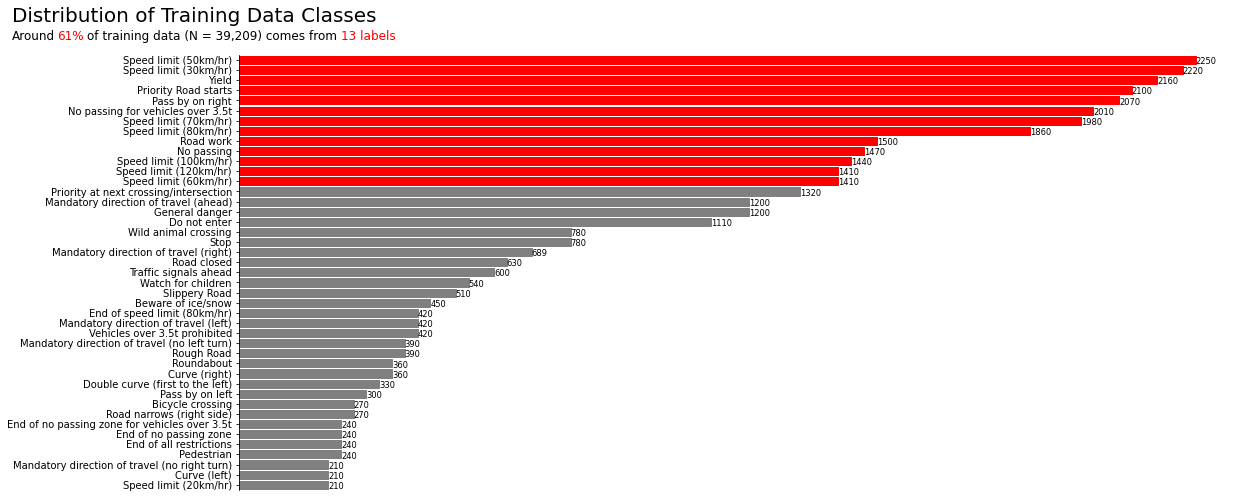

In [ ]:
d = collections.Counter(train_labels)

df = pd.DataFrame.from_dict(d, orient = 'index').reset_index()
df.columns = ['Class', 'Count']
df['Class_label'] = df['Class'].map(class_label_dict)
df['Class'] = df['Class'].astype(str)
df = df.sort_values(['Count', 'Class'], ascending = False).reset_index()

fig, ax = plt.subplots(figsize = (18,8))
fig.text(-0.05, 0.93, "Distribution of Training Data Classes", ha= "left", va="bottom", size=20)
fig.text(-0.05, 0.9, "Around", ha= "left", va="bottom", size=12)
fig.text(-0.015, 0.9, "{}%".format(int(round(df[df.Count > 1400]['Count'].sum()/len(train_labels),2)*100)), 
         ha= "left", va="bottom", size=12, color = 'red')
fig.text(0.008, 0.9, 'of training data (N = {:,}) comes from'.format(len(train_data)), 
         ha= "left", va="bottom", size=12)
fig.text(0.204, 0.9, "13 labels", ha= "left", va="bottom", size=12, color = 'red')

g = sns.barplot(y = 'Class_label', x = 'Count', data = df)
for p in g.patches:
  if p.get_width() > 1400:
    p.set_color('Red')    
  else:
    p.set_color('Grey')
  xpos = p.get_x() + p.get_width() 
  ypos = p.get_y() + p.get_height() 
  value = int(p.get_width())
  g.text(xpos, ypos, value, ha="left", size = "small")

g.set(xlabel = None, ylabel = None, xticklabels = [], xticks = [])
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False)

plt.show()

In [ ]:
train_data_dim_li = []
for i in range(len(train_data)):
  train_data_dict = {'Class': train_labels[i], 'Height': train_data[i].shape[0], 'Width':train_data[i].shape[1]}
  train_data_dim_li.append(train_data_dict)
train_data_dim_df = pd.DataFrame(train_data_dim_li)
train_data_dim_df2 = train_data_dim_df.copy()

train_data_dim_df = train_data_dim_df.sort_values('Class').reset_index()
train_data_dim_df['Class'] = train_data_dim_df['Class'].astype(str)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,7))
g1 = sns.histplot(train_data_dim_df, x = 'Height',  ax = ax[0])
ax[0].axvline(x=train_data_dim_df['Height'].mean(), color='r', label = "Mean", linestyle = 'dashed')
g2 = sns.histplot(train_data_dim_df, x = 'Width', ax = ax[1])
ax[1].axvline(x=train_data_dim_df['Width'].mean(), color='r', label = "Mean", linestyle = 'dashed')
g1.set(ylabel = None, xlabel = None, title = 'Height Histogram')
g2.set(ylabel = None, xlabel = None, title = 'Width Histogram')
plt.show()

In [ ]:
print('Mean of training images height: {}'.format(train_data_dim_df['Height'].mean()))
print('Mean of training images width: {}'.format(train_data_dim_df['Width'].mean()))
print('Median of training images height: {}'.format(train_data_dim_df['Height'].median()))
print('Median of training images width: {}'.format(train_data_dim_df['Width'].median()))

Mean of training images height: 50.328929582493814
Mean of training images width: 50.83587951745773
Median of training images height: 43.0
Median of training images width: 43.0


In [ ]:
output_notebook()

sizes = train_data_dim_df.groupby(['Height', 'Width']).size().reset_index().rename(columns={0:'count'})
sizes['count_scaled'] = sizes['count']/4
p = figure(title = "Height vs. Width Bubbleplot", x_axis_label='Height', y_axis_label='Width')
p.circle('Height','Width',source=sizes,fill_alpha=0.05, size='count_scaled')
show(p)

In [ ]:
from numpy import histogram, linspace

train_data_dim_df['Aspect Ratio'] = train_data_dim_df['Width'] / train_data_dim_df['Height']
train_data_dim_df.sort_values('Aspect Ratio', ascending = False) 
p = figure(plot_height=300, title = 'Aspect Ratio Histogram')
# plot actual hist for comparison
hist, edges = histogram(train_data_dim_df['Aspect Ratio'], bins = 80)
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.6)

show(p)

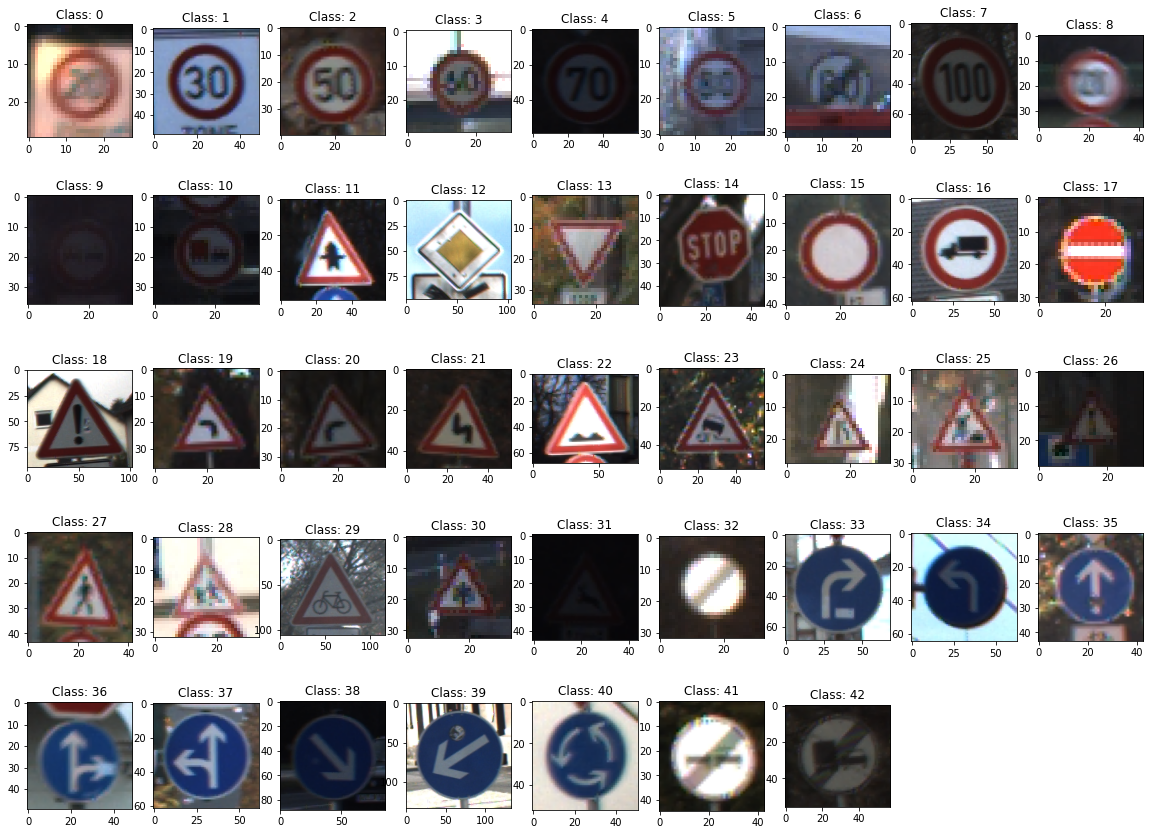

In [ ]:
def plot_random_images(dir): 
  '''
  This function plots one random image from each of the 43 training data classes
  '''
  random_train_data = []
  random_train_labels = []
  train_folders = sorted(os.listdir(dir))

  for folder in train_folders:
    csv_file = [x for x in os.listdir(os.path.join(dir,folder)) if x.endswith('.csv')]
    df = pd.read_csv(os.path.join(dir,folder, csv_file[0]), sep = ';')
    files = [x for x in os.listdir(os.path.join(dir, folder)) if x.endswith('.ppm')]
    random_file = random.choice(files)
    image = imread(os.path.join(dir, folder, random_file))
    random_train_data.append(image)
    random_train_labels.append(int(df[df.Filename == random_file]['ClassId']))
  
  fig = plt.figure(figsize=(20, 15))
  plt.subplots_adjust(wspace = 0.2)
  columns = 9
  rows = 5
  for i in range(1, columns*rows +1):
    if i > 43:
      continue
    else:
      fig.add_subplot(rows, columns, i)
      plt.imshow(random_train_data[i-1])
      plt.title('Class: {}'.format(random_train_labels[i-1]))
  plt.show()

plot_random_images(main_train_dir)



In [ ]:
def plot_similar_images():
  '''
  This function plots similar images found in the train dataset (randomly for 7 classes). 
  Currently, each class folder contains files with names of the format xxxxx-xxxxx.ppm. A trend can 
  be observed in the file names whereby the first five numbers might refer to the unique image/scene 
  whereas the second five numbers can be interpreted as the version of said image/scene. 
  We have two plausible theories here:

  1) Either image augmentation was conducted on unique images from each class
  
  OR

  2) Images were taken during different times of day and/or from different angles

  We lean towards the second option, but the fact remains that there might be redundancy in 
  the train dataset which could influence our performance metrics.
  '''
  random_cls = random.sample(set(train_labels), 7)
  st_img = []
  for elem in random_cls:
    indices = np.where(np.array(train_labels) == elem)[0]
    k_train = np.array(train_data)[indices]
    k_file_name = np.array(train_file_name)[indices]
    k_split = [t.split('_')[0] for t in list(k_file_name)]
    choice = random.sample(k_split, 1)
    indices_choice = np.where(np.array([p.startswith(choice[0]) for p in list(k_file_name)]))[0]
    filtered_train = k_train[indices_choice]
    filtered_train_file = k_file_name[indices_choice]
    comb = random.sample(list(zip(filtered_train, filtered_train_file)), 7)
    st_img.append(comb)

  fig, ax = plt.subplots(7,7, figsize = (15,15))
  for row in range(7):
    for col in range(7):
      ax[row,col].imshow(st_img[row][col][0])
      ax[row,col].set_title(st_img[row][col][1],size = 10)
      ax[row,col].axis('off')
    
  
plot_similar_images()


In [ ]:
def get_unique_scene_counts():
  verify = {i:{'Class Count': 0, 'Scene Count':0} for i in range(len(set(train_labels)))}
  for j in range(len(set(train_labels))):
    indices = np.where(np.array(train_labels) == j)[0]
    k_train = np.array(train_data)[indices]
    k_file_name = np.array(train_file_name)[indices]
    k_split = [t.split('_')[0] for t in list(k_file_name)]
    verify[j]['Class Count'] = len(k_split)
    verify[j]['Scene Count'] = len(set(k_split))
  
  d = pd.DataFrame.from_dict(verify,orient='index').reset_index().rename(columns={'index':'Class'})
  d['Class'] = d['Class'].map(class_label_dict)
  d['Class'] = d['Class'].astype(str)
  d = d.sort_values(['Scene Count', 'Class'], ascending = False).reset_index()
  fig, ax = plt.subplots(figsize = (18,8))
  fig.text(-0.05, 0.93, "Count of Unique Scenes from Training Data Classes", ha= "left", va="bottom", size=20)
  fig.text(-0.05, 0.9, "Numbers in " +  r"$\bf{" + 'bold' + "}$" + ' refer to counts of ' + r"$\bf{" + 'unique' + "}$" + ' image scenes whereas numbers in paranthesis refer to total class counts', ha= "left", va="bottom", size=12)
  g = sns.barplot(y = 'Class', x = 'Scene Count', data = d)
  i = 0
  for p in g.patches:
    p.set_color('Grey')
    xpos = p.get_x() + p.get_width() 
    ypos = p.get_y() + p.get_height() 
    value = '{} ({})'.format(r"$\bf{" + str(int(p.get_width())) + "}$", d['Class Count'][i]) 
    g.text(xpos, ypos, value, ha="left", size = "small")
    i += 1

  g.set(xlabel = None, ylabel = None, xticklabels = [], xticks = [])
  sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False)

  print('Total unique scenes: {}'.format(d['Scene Count'].sum()))
    
get_unique_scene_counts()


Total unique scenes: 1307


In [ ]:
def plot_low_contrast_images(data):
  '''
  This function plots an RMS histogram of greyscaled and normalized images, along
  with a set of low contrast images from a subset of the original training data
  Ref: https://en.wikipedia.org/wiki/Contrast_(vision)#RMS_contrast
  '''
  rms_values = []
  for img in data:
    mod_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mod_img_norm = mod_img/255
    mod_img_RMS = mod_img_norm.std()
    rms_values.append(mod_img_RMS)
  
  rms_df = pd.DataFrame(rms_values).rename(columns={0:'RMS'})
  plt.figure(figsize=(7, 5.5))
  g = sns.histplot(data=rms_df, x="RMS", kde=True)
  g.set_title("RMS Histogram")

  indices = np.where(np.array(rms_values) < 0.05)
  k = list(indices[0])
  low_rms_indices = random.sample(k, 40)
  rows = 4
  columns = 5

  fig = plt.figure(figsize=(15, 10))
  plt.subplots_adjust(wspace = 0.2)
  
  for i in range(1, rows*columns + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_data[low_rms_indices[i-1]])
  plt.show()

plot_low_contrast_images(train_data)


# 3) Data Preparation

## 3.1) Data Preprocessing

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
def split_images(data):
  '''
  This function uses splits the training dataset into train/validation sets using
  stratified sampling (including shuffle since image are originally loaded by order
  of files). Shuffle is necessary to avoid having a scenario where train and validation
  sets have different sets of consectutive classes. 
  '''
  split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=88)
  X = np.array(data.copy())
  y = np.array(train_labels)
  for train_index, test_index in split.split(X, y):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
  return X_train, X_val, y_train, y_val

In [ ]:
def preprocess_images(height, width, crop = None, greyscale = None, equalize_hist = None, original = False, oversampled = None):

  '''
  This function applies preproccesing steps on the given image data. It does so in the following ways:

  If oversampled is False:

    -> Split training data in to train/validation sets using sklearn's stratified shuffle split. While this isn't strictly necessary if
    not performing image augmentation as keras has a validation_split parameter in the fit() method, using image augmentation through
    ImageDataGenerator() will also apply augmentation on the validation set which should not be done. Since we will be using image augmentation,
    it's easiest if we just split the train/validation set here instead of doing so seperately each time later.
  
  If oversampled is True:
    -> Specify whether train data should both be augmented and oversampled (instead of data augmentation on the fly using Keras's .flow() method) 
    such that all training classes are equally represented.
  
  Implemented Cases:
  
  1) Non-oversampled cases:
    -> Resize original colored images: Set original to True
    -> Crop and resize: Set crop to True 
    -> Greyscale and resize: Set greyscale to True 
    -> Crop, greyscale and resize: Set greyscale and crop to True 
    -> Greyscale, resize, and histogram equalization: Set greyscale and equalize_hist to True
    -> Crop, resize, greyscale, and histogram equalization: Set crop, greyscale, and equalize_hist to True
  
  2) Oversampled Cases:
    -> Just resize oversampled and augmented colored images: Set original and oversampled to True
    -> Apply greyscale and resize: Set greyscale and oversampled to True
    -> Apply greyscale, resize, and histogram equalization: Set greyscale, equalize_hist, and oversampled to True

  Returns:
  -> X_train, X_test, X_val: preprocessed train, test, and validation splits as numpy arrays
  -> y_train, y_test, y_val: class labels for train, test, validation splits as numpy arrays
    '''

  if original:
    if not oversampled:
      X_train, X_val, y_train, y_val = split_images(train_data)
    else:
      X_train, y_train, X_val, y_val = oversample_augment_trainImages()
    X_test = test_data.copy()
    X_train = [cv2.resize(img, (width,height)) for img in X_train] 
    X_test = [cv2.resize(img, (width,height)) for img in X_test] 
    X_val = [cv2.resize(img, (width,height)) for img in X_val]
  else:
    if crop:
      merged = [[train_data[i], train_bounding_box[i]] for i in range(len(train_data))]
      X_train, X_val, y_train, y_val = split_images(merged)
      X_test = test_data.copy()
      X_train_cropped = []
      for img, bounding_b in X_train:
        x1 = bounding_b['Roi.X1']
        x2 = bounding_b['Roi.X2']
        y1 = bounding_b['Roi.Y1']
        y2 = bounding_b['Roi.Y2']
        cropped = img[x1:x2, y1:y2]
        X_train_cropped.append(cropped)
      X_train = X_train_cropped

      X_test_cropped = []
      for i in range(len(X_test)):
        x1 = test_bounding_box[i]['Roi.X1']
        x2 = test_bounding_box[i]['Roi.X2']
        y1 = test_bounding_box[i]['Roi.Y1']
        y2 = test_bounding_box[i]['Roi.Y2']
        cropped = test_data[i][x1:x2, y1:y2]
        X_test_cropped.append(cropped)
      X_test = X_test_cropped

      X_val_cropped = []
      for img, bounding_b in X_val:
        x2 = bounding_b['Roi.X2']
        x1 = bounding_b['Roi.X1']
        y1 = bounding_b['Roi.Y1']
        y2 = bounding_b['Roi.Y2']
        cropped = img[x1:x2, y1:y2]
        X_val_cropped.append(cropped)
      X_val = X_val_cropped

      X_train = [cv2.resize(img, (width,height)) for img in X_train] 
      X_test = [cv2.resize(img, (width,height)) for img in X_test]
      X_val = [cv2.resize(img, (width,height)) for img in X_val] 

    if greyscale:
      if crop:
        X_train = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_train]
        X_test = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_test]
        X_val = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_val]
      else:
        if not oversampled:
          X_train, X_val, y_train, y_val = split_images(train_data)
        else:
          X_train, y_train, X_val, y_val = oversample_augment_trainImages()
        
        X_test = test_data.copy()
        X_train = [cv2.resize(img, (width,height)) for img in X_train] 
        X_test = [cv2.resize(img, (width,height)) for img in X_test] 
        X_val = [cv2.resize(img, (width,height)) for img in X_val]

        X_train = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_train]
        X_test = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_test]
        X_val = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X_val]

    if equalize_hist:
      if greyscale:
        updated_X_train = []
        for img in X_train:
          clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
          cl1 = clahe.apply(img)
          updated_X_train.append(cl1)
        X_train = updated_X_train

        updated_X_test = []
        for img in X_test:
          clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
          cl1 = clahe.apply(img)
          updated_X_test.append(cl1)
        X_test = updated_X_test

        updated_X_val = []
        for img in X_val:
          clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
          cl1 = clahe.apply(img)
          updated_X_val.append(cl1)
        X_val = updated_X_val

  X_train = np.array(X_train)
  X_test = np.array(X_test)
  X_val = np.array(X_val)
  
  y_test = np.array(test_labels)
  
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  X_val = X_val.astype('float32')

  X_train /= 255
  X_test /= 255
  X_val /= 255

  return X_train, y_train, X_test, y_test, X_val, y_val


In [ ]:
def preprocessing_plots(height, width):

  '''
  This function plots original, cropped, greyscale, and histogram equalized images for 5 random training classes
  to assess the impact of various preproccesing methodologies.
  '''
  X_train_original, y_train_original, X_test_original, y_test_original, X_val_original, y_val_original = preprocess_images(height, width, original = True) # train/validation split, shuffle is necessary since data was added in order of categories
  X_train_cropped, y_train_cropped, X_test_cropped, y_test_cropped, X_val_cropped, y_val_cropped = preprocess_images(height, width, crop = True, greyscale = False, equalize_hist=False)
  X_train_cropped_grey, y_train_cropped_grey, X_test_cropped_grey, y_test_cropped_grey, X_val_cropped_grey, y_val_cropped_grey = preprocess_images(height, width, crop = True, greyscale = True, equalize_hist=False)
  X_train_cropped_greyeq, y_train_cropped_greyeq, X_test_cropped_greyeq, y_test_cropped_greyeq, X_val_cropped_greyeq, y_val_cropped_greyeq = preprocess_images(height, width, crop = True, greyscale = True, equalize_hist=True)
  X_train_grey, y_train_grey, X_test_grey, y_test_grey, X_val_grey, y_val_grey = preprocess_images(height, width, crop = False, greyscale = True, equalize_hist=False)
  X_train_greyeq, y_train_greyeq, X_test_greyeq, y_test_greyeq, X_val_greyeq, y_val_greyeq = preprocess_images(height, width, crop = False, greyscale = True, equalize_hist=True)

  fig, ax = plt.subplots(5, 6, figsize = (15,15))

  random_selections = random.sample(list(zip(X_train_original,X_train_grey, X_train_cropped, X_train_cropped_grey,X_train_greyeq, X_train_cropped_greyeq)), 5)
  types = ["Original\nImage", "Greyscaled\nImage", "Cropped\nOriginal", "Greyscale\nCropped", "Greyscaled +\nHistogram Equalization", "Greyscale +\nCrop +\nHistogram\nEqualization"]
  row = 0
  for elem in random_selections:
    col = 0
    for img in elem:
      if col in [0,2]:
        ax[row,col].imshow(img)
      else:
        ax[row,col].imshow(img, cmap = 'gray')
      if row == 0:
        ax[row,col].set_title(types[col])
      ax[row,col].axis('off')
      col += 1
    row += 1
  

In [ ]:
preprocessing_plots(30,30)

## 3.1) Data Augmentation

In [ ]:
def plot_images_after_augmentation():
  '''
  This function plots the visual changes that occur to 5 random training images
  after conducting data augmentation.
  '''
  random_images = random.sample(train_data, 5)
  datagen = ImageDataGenerator(
      rotation_range=10,
      zoom_range=0.1,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.15,
      fill_mode="nearest")
  
  fig, ax = plt.subplots(5, 7, figsize = (15,15))
  plt.subplots_adjust(wspace = 0.2)

  row = 0
  for img in random_images:
    col = 0
    ax[row,col].imshow(img)
    ax[row, col].axis('off')
    ax[row, 0].set_title('Original\nImage')
    samples = np.expand_dims(img, 0)
    for i in range(1,7):
      col = 1
      it = datagen.flow(samples, batch_size=1)
      batch = it.next()
      image = batch[0].astype('uint8')
      ax[row, i].imshow(image)
      ax[row, i].axis('off')
      ax[row,1].set_title('Augmented\nImages --> ')
    row += 1
  
plot_images_after_augmentation()

In [ ]:
def oversample_augment_trainImages():
  '''
  This function splits training data into train/validation sets, oversamples + augments (rotates, shears, zooms, width and height shifts) 
  the train set such that all class labels are equally represented. 
  Important note: Data augmentation is NOT conducted on the validation set.
  '''
  X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42, shuffle = True) 
  labels_counter = collections.Counter(y_train)
  images_df = pd.DataFrame({"Label": y_train, "Values": X_train})
  d = images_df.groupby('Label')['Values'].apply(list).to_dict()
  augmented_images = []
  augmented_labels = []
  datagen = ImageDataGenerator(
      rotation_range=10,
      zoom_range=0.1,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.15,
      fill_mode="nearest")
  for k,v in d.items():
    if len(v) > max(labels_counter.values())/2:
      random.seed(42)
      random_remain = random.sample(v, max(labels_counter.values()) - len(v))
      for img in v:
        augmented_images.append(img)
        augmented_labels.append(k)
      for img in random_remain:  
        samples = np.expand_dims(img, 0)
        it = datagen.flow(samples, batch_size=1)
        batch = it.next()
        image = batch[0].astype('uint8')
        augmented_images.append(image)
        augmented_labels.append(k)
    else:
      for img in v:
        augmented_images.append(img)
        augmented_labels.append(k)
        samples = np.expand_dims(img, 0)
        it = datagen.flow(samples, batch_size=1)
        for i in range(round((max(labels_counter.values())-len(v))/(len(v)))): # This part introduces round-off errors (oversample or undersample some labels)
          batch = it.next()
          image = batch[0].astype('uint8')
          augmented_images.append(image)
          augmented_labels.append(k)

  # Fix over/under sampling
  p = collections.Counter(augmented_labels) 
  images_df_aug = pd.DataFrame({"Label": augmented_labels, "Values": augmented_images})
  d_aug = images_df.groupby('Label')['Values'].apply(list).to_dict()
  d_aug = images_df_aug.groupby('Label')['Values'].apply(list).to_dict()
  aug_prop = []
  aug_prop_l = []

  for k,v in d_aug.items():
    if p[k] == max(labels_counter.values()):
      for img in v:
        aug_prop.append(img)
        aug_prop_l.append(k)
    elif p[k] > max(labels_counter.values()):
      random.seed(42)
      remain = random.sample(v, max(labels_counter.values()))
      for img in remain:
        aug_prop.append(img)
        aug_prop_l.append(k)
    else:
      random.seed(42)
      remain = random.sample(v, max(labels_counter.values()) - len(v))
      for img in v:
        aug_prop.append(img)
        aug_prop_l.append(k)
      for img in remain:
        samples = np.expand_dims(img, 0)
        it = datagen.flow(samples, batch_size=1)
        batch = it.next()
        image = batch[0].astype('uint8')
        aug_prop.append(image)
        aug_prop_l.append(k)
  
  X_train = aug_prop
  y_train = aug_prop_l
  X_train, y_train = shuffle(X_train, y_train, random_state = 42)
  return X_train, y_train, X_val, y_val



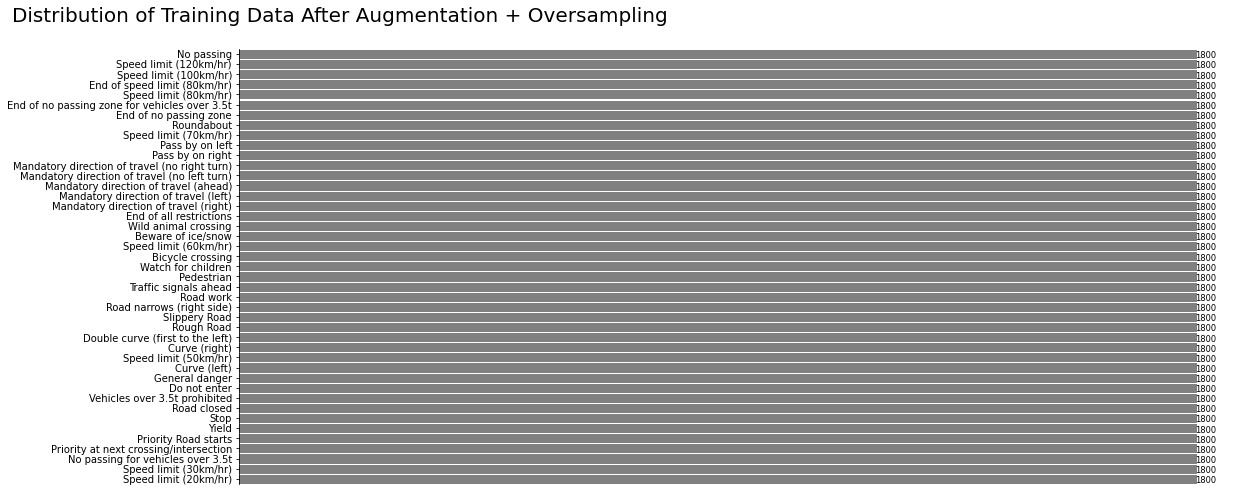

In [ ]:
X_train_a, y_train_a, X_val_a, y_val_a = oversample_augment_trainImages()
d = collections.Counter(y_train_a)

df = pd.DataFrame.from_dict(d, orient = 'index').reset_index()
df.columns = ['Class', 'Count']
df['Class_label'] = df['Class'].map(class_label_dict)
df['Class'] = df['Class'].astype(str)
df = df.sort_values(['Count', 'Class'], ascending = False).reset_index()

fig, ax = plt.subplots(figsize = (18,8))
fig.text(-0.05, 0.92, "Distribution of Training Data After Augmentation + Oversampling", ha= "left", va="bottom", size=20)
g = sns.barplot(y = 'Class_label', x = 'Count', data = df)
for p in g.patches:
  p.set_color('Grey')
  xpos = p.get_x() + p.get_width() 
  ypos = p.get_y() + p.get_height() 
  value = int(p.get_width())
  g.text(xpos, ypos, value, ha="left", size = "small")

g.set(xlabel = None, ylabel = None, xticklabels = [], xticks = [])
sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False)


# 4) Model Building

##4.1 - Neural Networks

In [ ]:
model_trial = keras.models.Sequential()
model_trial.add(keras.layers.Flatten(input_shape=[30, 30, 3]))
model_trial.add(keras.layers.Dense(300, activation="relu"))   
model_trial.add(keras.layers.Dense(100, activation="relu"))
model_trial.add(keras.layers.Dense(43, activation="softmax"))
model_trial.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(30, 30, original = True)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

history = model_trial.fit(X_train, y_train,
              batch_size=30,
              epochs=30,
              validation_data = (X_val, y_val)) 

Epoch 1/30
1046/1046 [==============================] - 6s 6ms/step - loss: 1.9621 - accuracy: 0.4843 - val_loss: 1.0333 - val_accuracy: 0.7332
Epoch 2/30
1046/1046 [==============================] - 6s 5ms/step - loss: 0.8401 - accuracy: 0.7698 - val_loss: 0.6976 - val_accuracy: 0.8078
Epoch 3/30
1046/1046 [==============================] - 6s 5ms/step - loss: 0.5991 - accuracy: 0.8328 - val_loss: 0.5964 - val_accuracy: 0.8310
Epoch 4/30
1046/1046 [==============================] - 5s 5ms/step - loss: 0.4900 - accuracy: 0.8652 - val_loss: 0.4649 - val_accuracy: 0.8582
Epoch 5/30
1046/1046 [==============================] - 6s 5ms/step - loss: 0.4208 - accuracy: 0.8841 - val_loss: 0.4275 - val_accuracy: 0.8857
Epoch 6/30
1046/1046 [==============================] - 6s 5ms/step - loss: 0.3757 - accuracy: 0.8962 - val_loss: 0.3970 - val_accuracy: 0.8956
Epoch 7/30
1046/1046 [==============================] - 5s 5ms/step - loss: 0.3350 - accuracy: 0.9053 - val_loss: 0.4307 - val_accuracy:

In [ ]:
def plot_loss_acc(hist):
  train_val_scores = {
  "Train Accuracy": hist.history['accuracy'],
  "Validation Accuracy": hist.history['val_accuracy'],
  "Validation Loss": hist.history['val_loss'],
  "Train Loss": hist.history['loss']
  }
  scores_df = pd.DataFrame(train_val_scores)
  scores_df = pd.melt(scores_df[["Train Accuracy", "Validation Accuracy", "Train Loss", "Validation Loss"]].reset_index(),
                    id_vars = "index", var_name = "Type", value_name = "Value")
  scores_df_f1 = scores_df[(scores_df["Type"] == "Train Accuracy") | (scores_df["Type"] == "Validation Accuracy")]
  scores_df_f2 = scores_df[(scores_df["Type"] == "Train Loss") | (scores_df["Type"] == "Validation Loss")]
  fig, ax = plt.subplots(2, 1, figsize = (7,10))
  g1 = sns.lineplot(x = "index", y = "Value",
             data = scores_df_f1,
             hue = "Type",ax = ax[0])
  g1.set(ylabel = "Accuracy", xlabel = None)
  g1.legend_.set_title(None)

  g2 = sns.lineplot(x = "index", y = "Value",
             data = scores_df_f2,
             hue = "Type", ax = ax[1])
  g2.set(ylabel = "Loss", xlabel = "Epoch")
  g2.legend_.set_title(None)
  plt.show()


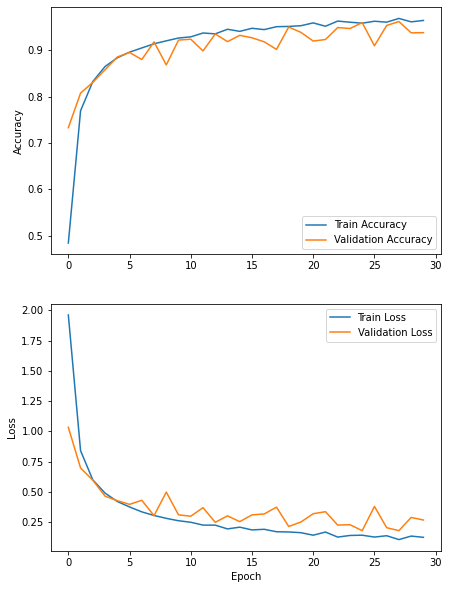

In [ ]:
plot_loss_acc(history)

In [ ]:
model_trial.evaluate(X_test, y_test)

395/395 [==============================] - 1s 4ms/step - loss: 1.3144 - accuracy: 0.8375


[1.3144339323043823, 0.837529718875885]

###4.1.1 - Phase 1: Baseline models (no data augmentation, stratified sampling)

In [ ]:
merged_scores = {}

In [ ]:
def model_run(preprocessing_type, height, width, epochs, act, opt, save_scores = True, augment = False, oversample = False):
  '''
  The following function runs a CNN model for various preprocessing techniques(obtained through the preprocess_images
  function defined above).
  It does so in three ways:
    1) baseline models where no data augmentation is conducted
    2) augmented models using the ImageDataGenerator .flow() method to conduct data augmentation on the fly
    3) oversampled (to account for class imbalance) and augmented models
  
  Args:
  -> preprocessing_type: String to define what preprocessing methodology to conduct. For ease of use,
  preprocessing_type should be one of: 'Colored', 'Colored + Crop', 'Greyscale', 'Greyscale + Crop',
  'Greyscale + Histogram Equalization', 'Greyscale + Crop + Histogram Equalization'
  -> height: Integer, what height the images should be resized to
  -> width: Integer, what width the images should be resized to
  -> epochs: Integer, number of training epochs to use
  -> act: activation function to use
  -> opt: optimizer to use
  -> augment: Boolean to indicate whether to conduct data augmentation on the fly
  -> oversample: Boolean to indicate whether to both oversample and augment
  -> save_scores: Boolean to indicate whether to save various model scores to a dictionary, merged_scores

  Returns:
  -> No return statement (unless preprocessing_type is not one of the strings listed above, whereby function returns nothing)
  If save_scores is True, updates merged_scores dictionary with model scores (accuracy, predicted labels, model history, etc..)
  '''
  if preprocessing_type == 'Colored':
    if not oversample:
      X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(height, width, original = True)
    else:
      X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(height, width, original = True, oversampled = True)
  elif preprocessing_type == 'Colored + Crop':
    X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(height, width, crop = True, greyscale = False, equalize_hist=False)
  elif preprocessing_type == 'Greyscale':
    if not oversample:
      X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(height, width, crop = False, greyscale = True, equalize_hist=False)
    else:
      X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(height, width, crop = False, greyscale = True, equalize_hist=False, oversampled = True)
  elif preprocessing_type == 'Greyscale + Crop':
    X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(height, width, crop = True, greyscale = True, equalize_hist=False)
  elif preprocessing_type == 'Greyscale + Histogram Equalization':
    if not oversample:
      X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(height, width, crop = False, greyscale = True, equalize_hist=True)
    else:
      X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(height, width, crop = False, greyscale = True, equalize_hist=True, oversampled = True)
  elif preprocessing_type == 'Greyscale + Crop + Histogram Equalization':
    X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(height, width, crop = True, greyscale = True, equalize_hist=True)
  else:
    print('Do not recognize preprocessing operation')
    return
  
  print(len(X_train), len(y_train))
  print(len(X_test), len(y_test))
  print(len(X_val), len(y_val))
  
  y_train = tf.keras.utils.to_categorical(y_train)
  y_test = tf.keras.utils.to_categorical(y_test)
  y_val = tf.keras.utils.to_categorical(y_val)

  if X_train.ndim == 4:
    model = keras.models.Sequential([
      keras.layers.Conv2D(30, 3, activation=act, padding="same",
                          input_shape=[height, width, 3]),
      keras.layers.Conv2D(30, 3, activation=act, padding="same"),
      keras.layers.MaxPooling2D(2),
      keras.layers.Conv2D(60, 3, activation=act, padding="same"),
      keras.layers.Conv2D(60, 3, activation=act, padding="same"),
      keras.layers.MaxPooling2D(2),
      keras.layers.Dropout(0.4),
      keras.layers.Flatten(),
      keras.layers.Dense(500, activation=act),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(43, activation="softmax")
  ])
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    if augment:
      aug = ImageDataGenerator(
      rotation_range=10,
      zoom_range=0.1,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.15,
      fill_mode="nearest")
      history = model.fit(aug.flow(X_train, y_train, batch_size = 60),
                    batch_size=30,
                    epochs = epochs,
                    validation_data = (X_val, y_val))
    else:
      history = model.fit(X_train, y_train,
              batch_size=30,
              epochs=epochs,
              validation_data = (X_val, y_val)) 
  else:
    model = keras.models.Sequential([
      keras.layers.Conv2D(30, 3, activation=act, padding="same",
                          input_shape=[height, width, 1]),
      keras.layers.Conv2D(30, 3, activation=act, padding="same"),
      keras.layers.MaxPooling2D(2),
      keras.layers.Conv2D(60, 3, activation=act, padding="same"),
      keras.layers.Conv2D(60, 3, activation=act, padding="same"),
      keras.layers.MaxPooling2D(2),
      keras.layers.Dropout(0.4),
      keras.layers.Flatten(),
      keras.layers.Dense(500, activation=act),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(43, activation="softmax")
  ])
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    if augment:
      aug = ImageDataGenerator(
      rotation_range=10,
      zoom_range=0.1,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.15,
      fill_mode="nearest")
      history = model.fit(aug.flow(X_train.reshape((X_train.shape[0], height, width, 1)), y_train, batch_size = 60),
                    batch_size=30,
                    validation_data = (X_val, y_val),
                    epochs = epochs)
    else:
      history = model.fit(X_train.reshape((X_train.shape[0], height, width, 1)), y_train,
                  batch_size=30,
                  epochs=epochs,
                  validation_data = (X_val, y_val)) 
  if save_scores:
    test_scores = model.evaluate(X_test, y_test, verbose= 0)
    y_pred = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)

    if (not augment) and (not oversample):
      merged_scores[preprocessing_type] = {}
      merged_scores[preprocessing_type]["Model Type"] = 'Base'
      merged_scores[preprocessing_type]["Sampling Type"] = 'Stratified'
      merged_scores[preprocessing_type]["Accuracy"] = test_scores[1]
      merged_scores[preprocessing_type]["Loss"] = test_scores[0]
      merged_scores[preprocessing_type]["Predicted Labels"] = y_pred
      merged_scores[preprocessing_type]["History"] = history
      merged_scores[preprocessing_type]["Precision"] = precision_score(test_labels, y_pred, average = 'macro')
      merged_scores[preprocessing_type]["Recall"] = recall_score(test_labels, y_pred, average = 'macro')
      merged_scores[preprocessing_type]["F1"] = f1_score(test_labels, y_pred, average = 'macro')
      merged_scores[preprocessing_type]["Optimizer"] = opt._keras_api_names
      merged_scores[preprocessing_type]["Activation"] = act._keras_api_names
      merged_scores[preprocessing_type]["Epochs"] = epochs

    elif augment and (not oversample):
      merged_scores[preprocessing_type + ' Augment'] = {}
      merged_scores[preprocessing_type + ' Augment']["Model Type"] = 'Augmented'
      merged_scores[preprocessing_type + ' Augment']["Sampling Type"] = 'Stratified'
      merged_scores[preprocessing_type + ' Augment']["Accuracy"] = test_scores[1]
      merged_scores[preprocessing_type + ' Augment']["Loss"] = test_scores[0]
      merged_scores[preprocessing_type + ' Augment']["Predicted Labels"] = y_pred
      merged_scores[preprocessing_type + ' Augment']["History"] = history
      merged_scores[preprocessing_type + ' Augment']["Precision"] = precision_score(test_labels, y_pred, average = 'macro')
      merged_scores[preprocessing_type + ' Augment']["Recall"] = recall_score(test_labels, y_pred, average = 'macro')
      merged_scores[preprocessing_type + ' Augment']["F1"] = f1_score(test_labels, y_pred, average = 'macro')
      merged_scores[preprocessing_type + ' Augment']["Optimizer"] = opt._keras_api_names
      merged_scores[preprocessing_type + ' Augment']["Activation"] = act._keras_api_names
      merged_scores[preprocessing_type + ' Augment']["Epochs"] = epochs
    else:
      merged_scores[preprocessing_type + ' Oversampled + Augmented'] = {}
      merged_scores[preprocessing_type + ' Oversampled + Augmented']["Model Type"] = 'Oversampled + Augmented'
      merged_scores[preprocessing_type + ' Oversampled + Augmented']["Sampling Type"] = 'Stratified'
      merged_scores[preprocessing_type + ' Oversampled + Augmented']["Accuracy"] = test_scores[1]
      merged_scores[preprocessing_type + ' Oversampled + Augmented']["Loss"] = test_scores[0]
      merged_scores[preprocessing_type + ' Oversampled + Augmented']["Predicted Labels"] = y_pred
      merged_scores[preprocessing_type + ' Oversampled + Augmented']["History"] = history
      merged_scores[preprocessing_type + ' Oversampled + Augmented']["Precision"] = precision_score(test_labels, y_pred, average = 'macro')
      merged_scores[preprocessing_type + ' Oversampled + Augmented']["Recall"] = recall_score(test_labels, y_pred, average = 'macro')
      merged_scores[preprocessing_type + ' Oversampled + Augmented']["F1"] = f1_score(test_labels, y_pred, average = 'macro')
      merged_scores[preprocessing_type + ' Oversampled + Augmented']["Optimizer"] = opt._keras_api_names
      merged_scores[preprocessing_type + ' Oversampled + Augmented']["Activation"] = act._keras_api_names
      merged_scores[preprocessing_type + ' Oversampled + Augmented']["Epochs"] = epochs

In [ ]:
preprocessing_types = ['Colored', 'Colored + Crop', 'Greyscale', 'Greyscale + Crop', 'Greyscale + Histogram Equalization', 'Greyscale + Crop + Histogram Equalization']
for elem in preprocessing_types:
  model_run(elem, height = 30, width = 30, epochs = 30, act=keras.layers.LeakyReLU(), opt=tf.keras.optimizers.Adadelta(learning_rate=0.9))

31367 31367
12630 12630
7842 7842
Epoch 1/30
1046/1046 [==============================] - 16s 6ms/step - loss: 0.8844 - accuracy: 0.7476 - val_loss: 0.0838 - val_accuracy: 0.9790
Epoch 2/30
1046/1046 [==============================] - 6s 5ms/step - loss: 0.1233 - accuracy: 0.9634 - val_loss: 0.0408 - val_accuracy: 0.9902
Epoch 3/30
1046/1046 [==============================] - 6s 5ms/step - loss: 0.0697 - accuracy: 0.9796 - val_loss: 0.0317 - val_accuracy: 0.9927
Epoch 4/30
1046/1046 [==============================] - 6s 5ms/step - loss: 0.0520 - accuracy: 0.9850 - val_loss: 0.0253 - val_accuracy: 0.9952
Epoch 5/30
1046/1046 [==============================] - 6s 5ms/step - loss: 0.0395 - accuracy: 0.9891 - val_loss: 0.0251 - val_accuracy: 0.9952
Epoch 6/30
1046/1046 [==============================] - 5s 5ms/step - loss: 0.0312 - accuracy: 0.9910 - val_loss: 0.0200 - val_accuracy: 0.9953
Epoch 7/30
1046/1046 [==============================] - 6s 5ms/step - loss: 0.0278 - accuracy: 0.9915

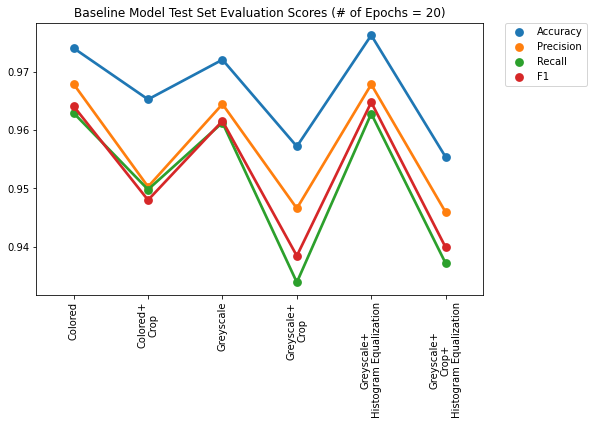

In [ ]:
scores_so_far_base = pd.DataFrame.from_dict(merged_scores,orient='index').reset_index().rename(columns={'index':'Preprocessing Type'}).drop(['History', 'Predicted Labels','Model Type', 'Loss', 'Sampling Type', 'Epochs', 'Activation', 'Optimizer'], axis = 1)
scores_so_far_u = pd.melt(scores_so_far_base, id_vars = "Preprocessing Type", var_name = "Metric", value_name = "Value")
types_new = [label.replace(' + ', '+\n') for label in scores_so_far_u['Preprocessing Type']]
scores_so_far_u['Preprocessing Type'] = types_new

fig, ax = plt.subplots(figsize = (8,5))
g = sns.pointplot(x = "Preprocessing Type", y = "Value", hue = "Metric", data = scores_so_far_u[scores_so_far_u.Metric != 'Test Loss'])
g.set(title = 'Baseline Model Test Set Evaluation Scores (# of Epochs = 20)', xlabel = None, ylabel = None)
plt.legend(bbox_to_anchor=(1.05, 1), loc = 2, borderaxespad=0.)
plt.xticks(rotation = 90)
plt.show()


In [ ]:
plot_loss_acc(merged_scores['Colored']["History"])

In [ ]:
plot_loss_acc(merged_scores['Greyscale']["History"])

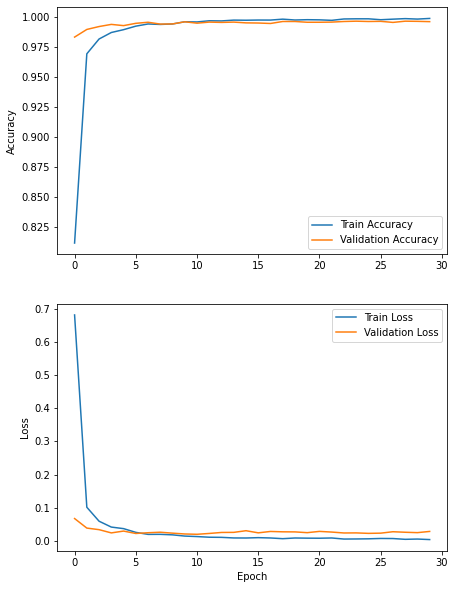

In [ ]:
plot_loss_acc(merged_scores['Greyscale + Histogram Equalization']["History"])

In [ ]:
scores_so_far_base

Preprocessing Type  Accuracy  Precision    Recall  \
0                                    Colored  0.974030   0.967865  0.962901   
1                             Colored + Crop  0.965241   0.950261  0.949778   
2                                  Greyscale  0.972051   0.964426  0.961250   
3                           Greyscale + Crop  0.957165   0.946539  0.933856   
4         Greyscale + Histogram Equalization  0.976247   0.967809  0.962799   
5  Greyscale + Crop + Histogram Equalization  0.955344   0.945875  0.937117   

         F1  
0  0.964067  
1  0.947971  
2  0.961536  
3  0.938392  
4  0.964751  
5  0.939842

###4.1.2 - Phase 2: Models with data augmentation, stratified sampling

In [ ]:
preprocessing_types = ['Colored', 'Colored + Crop', 'Greyscale', 'Greyscale + Crop', 'Greyscale + Histogram Equalization', 'Greyscale + Crop + Histogram Equalization']
for elem in preprocessing_types:
  model_run(elem, height = 30, width = 30, epochs = 30, act=keras.layers.LeakyReLU(), opt=tf.keras.optimizers.Adadelta(learning_rate=0.9), augment = True)

31367 31367
12630 12630
7842 7842
Epoch 1/30
523/523 [==============================] - 17s 31ms/step - loss: 1.9478 - accuracy: 0.4430 - val_loss: 0.4538 - val_accuracy: 0.8595
Epoch 2/30
523/523 [==============================] - 16s 31ms/step - loss: 0.6652 - accuracy: 0.7931 - val_loss: 0.1270 - val_accuracy: 0.9663
Epoch 3/30
523/523 [==============================] - 16s 31ms/step - loss: 0.4006 - accuracy: 0.8766 - val_loss: 0.0552 - val_accuracy: 0.9880
Epoch 4/30
523/523 [==============================] - 16s 30ms/step - loss: 0.2928 - accuracy: 0.9103 - val_loss: 0.0422 - val_accuracy: 0.9912
Epoch 5/30
523/523 [==============================] - 16s 30ms/step - loss: 0.2284 - accuracy: 0.9302 - val_loss: 0.0405 - val_accuracy: 0.9897
Epoch 6/30
523/523 [==============================] - 16s 30ms/step - loss: 0.1862 - accuracy: 0.9443 - val_loss: 0.0254 - val_accuracy: 0.9918
Epoch 7/30
523/523 [==============================] - 22s 42ms/step - loss: 0.1599 - accuracy: 0.9519 

In [ ]:
scores_so_far_aug = pd.DataFrame.from_dict(merged_scores,orient='index').reset_index().rename(columns={'index':'Preprocessing Type'}).drop(['History', 'Predicted Labels', 'Sampling Type','Epochs', 'Activation', 'Optimizer'], axis = 1)
scores_so_far_aug['Preprocessing Type'] = scores_so_far_aug['Preprocessing Type'].map(lambda x: x.replace(' Augment', ''))
t1 = pd.melt(scores_so_far_aug.drop("Loss", axis = 1), id_vars=['Preprocessing Type', 'Model Type'], var_name = "Metric", value_name = "Value")
fig, ax = plt.subplots(2,3, figsize = (13,7))
fig.tight_layout()
plt.subplots_adjust(hspace = 0.35)
preprocessing_types = ['Colored', 'Colored + Crop', 'Greyscale', 'Greyscale + Crop', 'Greyscale + Histogram Equalization', 'Greyscale + Crop + Histogram Equalization']
i = 0
for row in range(2):
  for col in range(3):
    g = sns.pointplot(x = 'Model Type', y = 'Value', hue = 'Metric', data = t1[t1['Preprocessing Type'] == preprocessing_types[i]], ax = ax[row,col])
    g.set(ylabel = None, xlabel = None)
    ax[row,col].get_legend().remove()
    ax[row,col].set_title(preprocessing_types[i])
    i += 1

ax[0,2].legend(bbox_to_anchor=(1.05, 1), loc = 2, borderaxespad=0.)
plt.show()

In [ ]:
scores_so_far_aug

Preprocessing Type Model Type  Accuracy      Loss  \
0                                     Colored       Base  0.974030  0.182258   
1                              Colored + Crop       Base  0.965241  0.258623   
2                                   Greyscale       Base  0.972051  0.195701   
3                            Greyscale + Crop       Base  0.957165  0.344472   
4          Greyscale + Histogram Equalization       Base  0.976247  0.163780   
5   Greyscale + Crop + Histogram Equalization       Base  0.955344  0.312892   
6                                     Colored  Augmented  0.985036  0.065401   
7                              Colored + Crop  Augmented  0.978068  0.105026   
8                                   Greyscale  Augmented  0.981552  0.065735   
9                            Greyscale + Crop  Augmented  0.974663  0.107807   
10         Greyscale + Histogram Equalization  Augmented  0.981235  0.084667   
11  Greyscale + Crop + Histogram Equalization  Augmented  0.969200  0.126396   

    Precision    Recall        F1  
0    0.967865  0.962901  0.964067  
1    0.950261  0.949778  0.947971  
2    0.964426  0.961250  0.961536  
3    0.946539  0.933856  0.938392  
4    0.967809  0.962799  0.964751  
5    0.945875  0.937117  0.939842  
6    0.978111  0.981730  0.978725  
7    0.966951  0.973594  0.969192  
8    0.967811  0.975904  0.970693  
9    0.973202  0.968875  0.969885  
10   0.973560  0.977303  0.974680  
11   0.953261  0.964123  0.956866

In [ ]:
plot_loss_acc(merged_scores['Colored Augment']["History"])

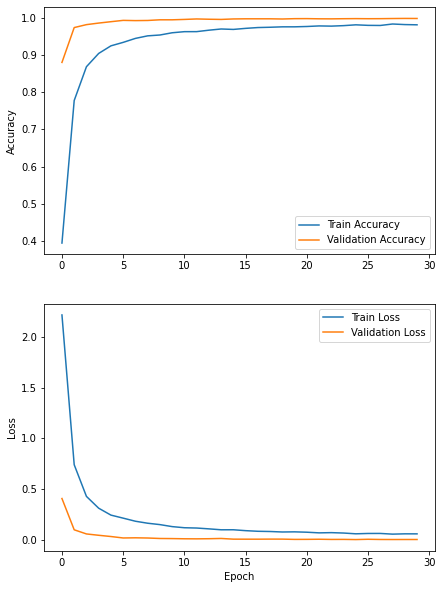

In [ ]:
plot_loss_acc(merged_scores['Greyscale Augment']["History"])

In [ ]:
plot_loss_acc(merged_scores['Greyscale + Histogram Equalization Augment']["History"])

###4.1.3 - Phase 3: Models with data augmentation + oversampling

In [ ]:
preprocessing_types_over = ['Colored', 'Greyscale', 'Greyscale + Histogram Equalization']
for elem in preprocessing_types_over:
    model_run(elem, height = 30, width = 30, epochs = 30, act=keras.layers.LeakyReLU(), opt=tf.keras.optimizers.Adadelta(learning_rate=0.9), oversample = True)


77400 77400
12630 12630
7842 7842
Epoch 1/30
2580/2580 [==============================] - 13s 5ms/step - loss: 0.8348 - accuracy: 0.7603 - val_loss: 0.0639 - val_accuracy: 0.9843
Epoch 2/30
2580/2580 [==============================] - 12s 5ms/step - loss: 0.1739 - accuracy: 0.9490 - val_loss: 0.0319 - val_accuracy: 0.9913
Epoch 3/30
2580/2580 [==============================] - 13s 5ms/step - loss: 0.1124 - accuracy: 0.9670 - val_loss: 0.0172 - val_accuracy: 0.9964
Epoch 4/30
2580/2580 [==============================] - 12s 5ms/step - loss: 0.0845 - accuracy: 0.9754 - val_loss: 0.0193 - val_accuracy: 0.9958
Epoch 5/30
2580/2580 [==============================] - 12s 5ms/step - loss: 0.0675 - accuracy: 0.9804 - val_loss: 0.0123 - val_accuracy: 0.9976
Epoch 6/30
2580/2580 [==============================] - 12s 5ms/step - loss: 0.0588 - accuracy: 0.9834 - val_loss: 0.0118 - val_accuracy: 0.9972
Epoch 7/30
2580/2580 [==============================] - 12s 5ms/step - loss: 0.0511 - accuracy: 

In [ ]:
scores_so_far_aug_over = pd.DataFrame.from_dict(merged_scores,orient='index').reset_index().rename(columns={'index':'Preprocessing Type'}).drop(['History','Predicted Labels', 'Sampling Type', 'Optimizer', 'Activation', 'Epochs'], axis = 1)
scores_so_far_aug_over.sort_values('Accuracy', ascending=False)
compare_cond = scores_so_far_aug_over['Preprocessing Type'].isin(['Greyscale Oversampled + Augmented', 'Greyscale Augment', 'Greyscale + Histogram Equalization Oversampled + Augmented',
                                                                'Colored Oversampled + Augmented', 'Greyscale + Histogram Equalization Augment', 'Colored Augment', 'Colored',
                                                                'Greyscale', 'Greyscale + Histogram Equalization'])
compare_df = scores_so_far_aug_over[compare_cond]
compare_df['Preprocessing Type'] = compare_df['Preprocessing Type'].map(lambda x: x.replace(' Augment', '') if x.endswith('Augment') else x.replace(' Oversampled + Augmented', ''))
t1 = pd.melt(compare_df.drop("Loss", axis = 1), id_vars=['Preprocessing Type', 'Model Type'], var_name = "Metric", value_name = "Value")
g = sns.catplot(x = "Model Type", y = "Value", hue = "Metric", data = t1, kind = "point", 
                  col = "Preprocessing Type", height = 6, aspect = 1)
g.set(ylabel = None, xlabel = None)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


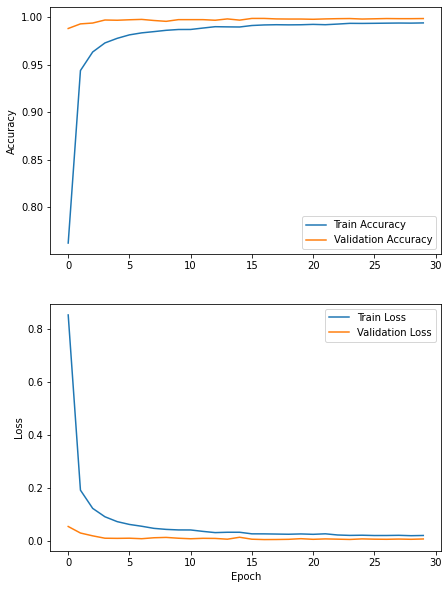

In [ ]:
plot_loss_acc(merged_scores['Greyscale Oversampled + Augmented']['History'])

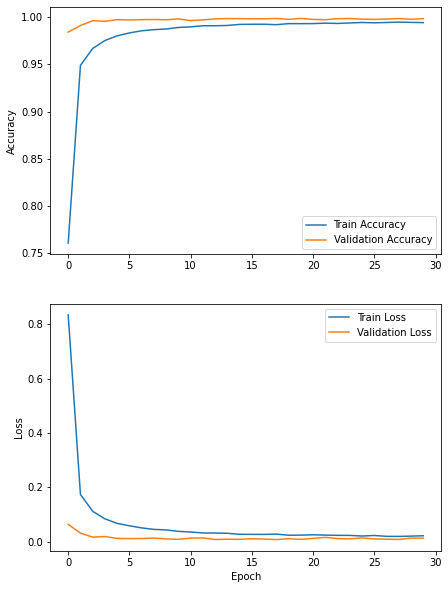

In [ ]:
plot_loss_acc(merged_scores['Colored Oversampled + Augmented']['History'])

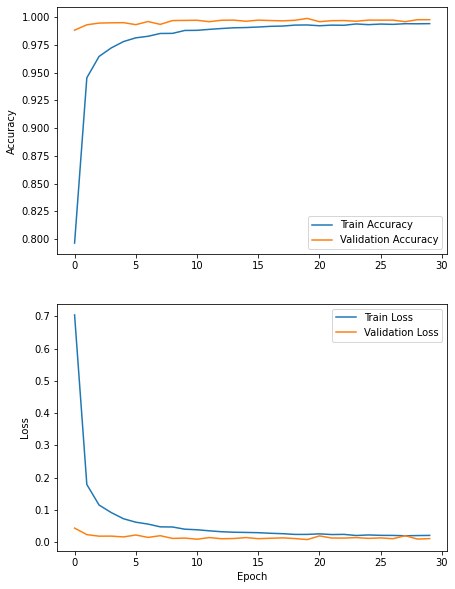

In [ ]:
plot_loss_acc(merged_scores['Greyscale + Histogram Equalization Oversampled + Augmented']['History'])

In [ ]:
scores_so_far_final = pd.DataFrame.from_dict(merged_scores,orient='index').reset_index().rename(columns={'index':'Preprocessing Type'}).drop(['History', 'Predicted Labels', 'Sampling Type', 'Activation',
                                                                                                                                                 'Epochs', 'Optimizer'], axis = 1)
scores_so_far_final

Preprocessing Type  \
0                                             Colored   
1                                      Colored + Crop   
2                                           Greyscale   
3                                    Greyscale + Crop   
4                  Greyscale + Histogram Equalization   
5           Greyscale + Crop + Histogram Equalization   
6                                     Colored Augment   
7                              Colored + Crop Augment   
8                                   Greyscale Augment   
9                            Greyscale + Crop Augment   
10         Greyscale + Histogram Equalization Augment   
11  Greyscale + Crop + Histogram Equalization Augment   
12                    Colored Oversampled + Augmented   
13                  Greyscale Oversampled + Augmented   
14  Greyscale + Histogram Equalization Oversampled...   

                 Model Type  Accuracy      Loss  Precision    Recall        F1  
0                      Base  0.974030  0.182258   0.967865  0.962901  0.964067  
1                      Base  0.965241  0.258623   0.950261  0.949778  0.947971  
2                      Base  0.972051  0.195701   0.964426  0.961250  0.961536  
3                      Base  0.957165  0.344472   0.946539  0.933856  0.938392  
4                      Base  0.976247  0.163780   0.967809  0.962799  0.964751  
5                      Base  0.955344  0.312892   0.945875  0.937117  0.939842  
6                 Augmented  0.985036  0.065401   0.978111  0.981730  0.978725  
7                 Augmented  0.978068  0.105026   0.966951  0.973594  0.969192  
8                 Augmented  0.981552  0.065735   0.967811  0.975904  0.970693  
9                 Augmented  0.974663  0.107807   0.973202  0.968875  0.969885  
10                Augmented  0.981235  0.084667   0.973560  0.977303  0.974680  
11                Augmented  0.969200  0.126396   0.953261  0.964123  0.956866  
12  Oversampled + Augmented  0.985036  0.082291   0.968385  0.982059  0.973865  
13  Oversampled + Augmented  0.986936  0.081217   0.977893  0.987507  0.982327  
14  Oversampled + Augmented  0.981314  0.082754   0.971464  0.979206  0.974816

###4.1.3 - Error Analysis

In [ ]:
def plot_incorrect_images(preprocessing_type1, compare = False):
  '''
  This function plots incorrect images through model scores stored in merged_scores (after running the model_run function above).
  It does so in the following ways:
  -> If compare is False(default): only plots incorrect images for baseline preprocessing type
  -> If compare is True: shows what images, originally identified as incorrect by the baseline models,
  have now been correctly classified by augmented models

  Examples:
  -> plot_incorrect_images('Greyscale') only shows a random sample (25) of incorrectly predicted
  images by the baseline model for greyscale preprocessing type
  -> plot_incorrect_images('Greyscale', compare = True) shows a random sample (25) of images that are
  now correctly classified after conducting data augmentation
  
  Args:
  -> preprocessing_type: String to define what preprocessing methodology to check predicted incorrect images. For ease of use,
  preprocessing_type should be one of: 'Colored', 'Colored + Crop', 'Greyscale', 'Greyscale + Crop',
  'Greyscale + Histogram Equalization', 'Greyscale + Crop + Histogram Equalization'
  -> compare: Boolean to check what images have been now correctly identified after augmentation

  '''
  if preprocessing_type1 == 'Colored':
    X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(30, 30, original = True)
  elif preprocessing_type1 == 'Colored + Crop':
    X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(30, 30, crop = True, greyscale = False, equalize_hist=False)
  elif preprocessing_type1 == 'Greyscale':
    X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(30, 30, crop = False, greyscale = True, equalize_hist=False)
  elif preprocessing_type1 == 'Greyscale + Crop':
    X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(30, 30, crop = True, greyscale = True, equalize_hist=False)
  elif preprocessing_type1 == 'Greyscale + Histogram Equalization':
    X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(30, 30, crop = False, greyscale = True, equalize_hist=True)
  elif preprocessing_type1 == 'Greyscale + Crop + Histogram Equalization':
    X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(30, 30, crop = True, greyscale = True, equalize_hist=True)
  else:
    print('Do not recognize preprocessing operation')
    return
  
  y_pred_base = merged_scores[preprocessing_type1]["Predicted Labels"]
  incorrect_images = list(np.where(np.not_equal(y_pred_base, test_labels))[0])
  rnd_wrong_indices = random.sample(list(incorrect_images), 25)
  
  if not compare:
    fig, ax = plt.subplots(5,5, figsize = (15,15))
    title = fig.suptitle("Incorrect predictions made by {} (base)".format(preprocessing_type1), fontsize="x-large")
    plt.subplots_adjust(hspace = 0.2)
    i = 0
    for row in range(5):
      for col in range(5):
        actual = test_labels[rnd_wrong_indices[i]]
        prediction = y_pred_base[rnd_wrong_indices[i]]
        ax[row, col].imshow(X_test[rnd_wrong_indices[i]], cmap = 'gray')
        ax[row,col].annotate('Actual: {}, '.format(actual), (6,-2), 
                             annotation_clip=False, ha = 'center', size = 12, color = 'green')
        ax[row,col].annotate('Predicted: {}'.format(prediction), (22,-2), 
                             annotation_clip=False, ha = 'center', size = 12, color = 'red')
        ax[row,col].axis('off')
        i+=1
    title.set_y(0.92)
  else:
    y_pred_aug = merged_scores[preprocessing_type1 + ' Augment']["Predicted Labels"]
    correct_images_aug = list(np.where(np.equal(y_pred_aug, test_labels))[0])
    improved = list(set(correct_images_aug).intersection(incorrect_images))
    # print(len(improved))
    rnd_indices_comp = random.sample(list(improved), 25)
    fig, ax = plt.subplots(5,5, figsize = (15,15))
    title = fig.suptitle("Improvements in Predictions for {} (Baseline) vs. {} (Augmented)".format(preprocessing_type1, preprocessing_type1), size = 14)
    plt.subplots_adjust(hspace = 0.5)
    i = 0
    for row in range(5):
      for col in range(5):
        actual = test_labels[rnd_indices_comp[i]]
        original_prediction = y_pred_base[rnd_indices_comp[i]]
        augmented_prediction = y_pred_aug[rnd_indices_comp[i]]
        ax[row, col].imshow(X_test[rnd_indices_comp[i]], cmap = 'gray')
        ax[row,col].annotate('Actual: {}'.format(actual), (15,-6.2), 
                             annotation_clip=False, ha = 'center', size = 10, color = 'green')
        ax[row,col].annotate('{}: {}'.format(preprocessing_type1, original_prediction), (15.2,-3.8), 
                             annotation_clip=False, ha = 'center', size = 10, color = 'red')
        ax[row,col].annotate('{}: {}'.format(preprocessing_type1 + ' Augmented', augmented_prediction), (15.2,-1.45), 
                             annotation_clip=False, ha = 'center', size = 10, color = 'green')
        ax[row,col].axis('off')
        i+=1
    title.set_y(0.93)

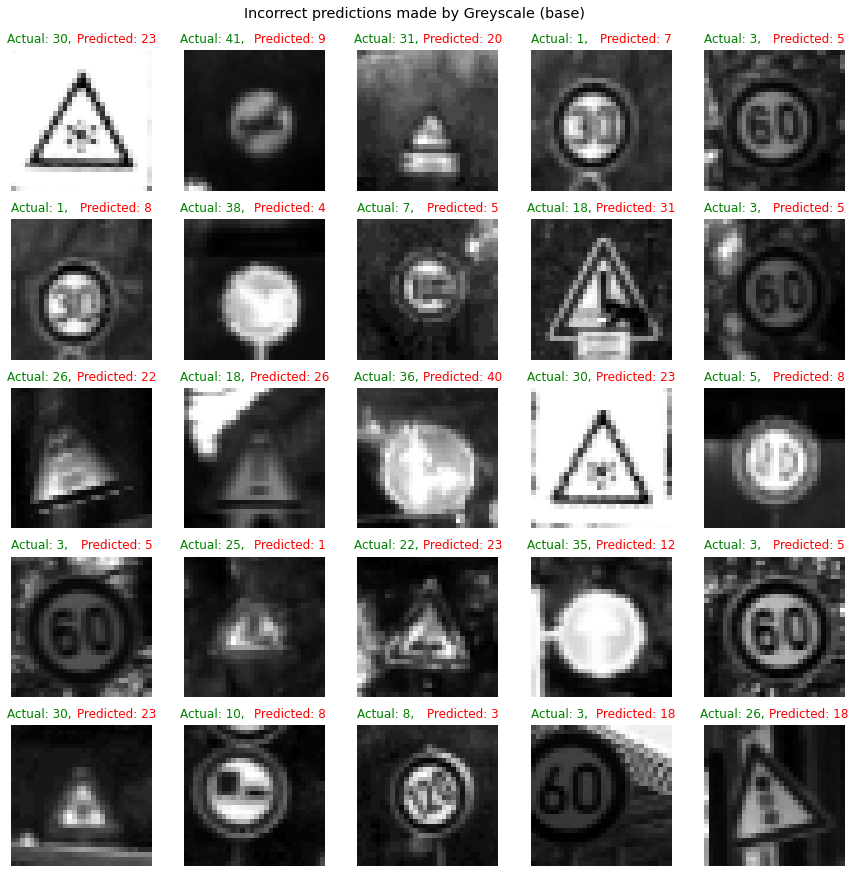

In [ ]:
plot_incorrect_images('Greyscale')

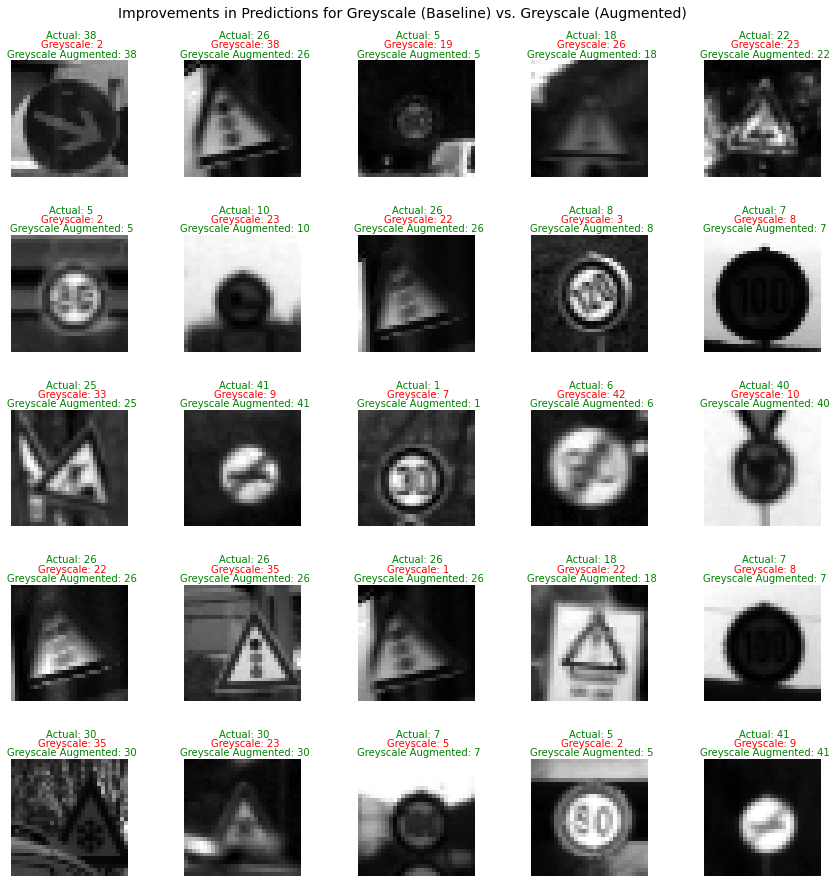

In [ ]:
plot_incorrect_images('Greyscale', compare = True)

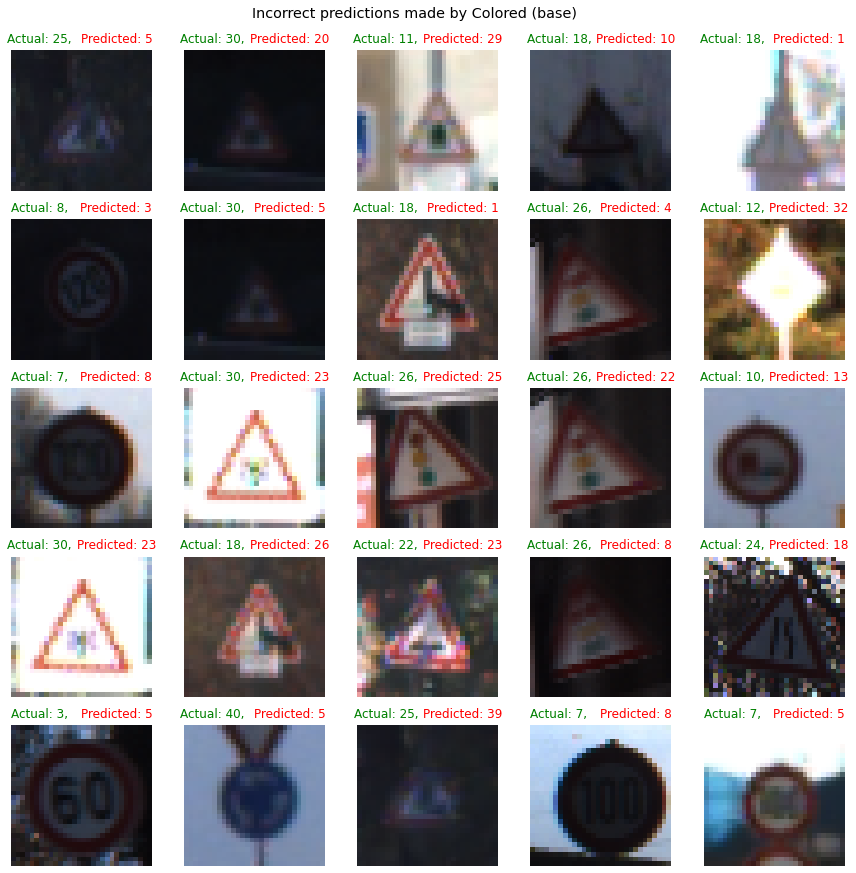

In [ ]:
plot_incorrect_images('Colored')

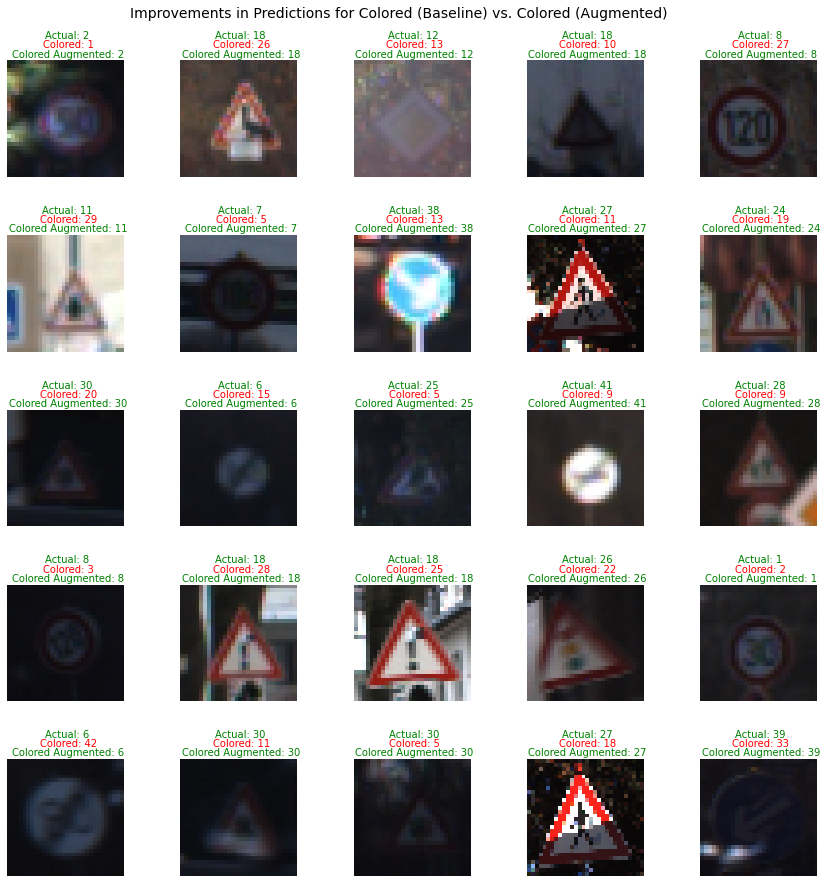

In [ ]:
plot_incorrect_images('Colored', compare = True)

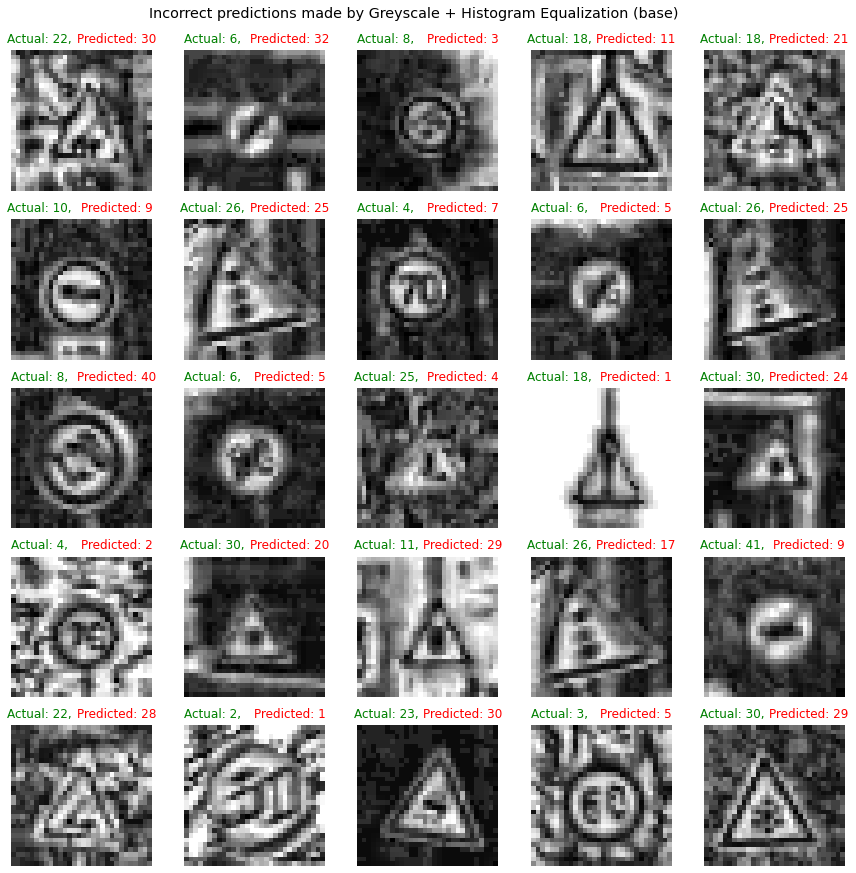

In [ ]:
plot_incorrect_images('Greyscale + Histogram Equalization')

In [ ]:
def select_col(x):
  c1 = 'color: green'
  c3 = 'color:red'
  c2 = '' 
  if ( 'f1-score',         'Greyscale') in x.keys():
    mask = x[( 'f1-score',         'Greyscale')] <= x[( 'f1-score', 'Greyscale Augment')]
    mask2 = x[( 'f1-score',         'Greyscale')] <= x[( 'f1-score', 'Greyscale Oversampled + Augmented')]
    df1 =  pd.DataFrame(c2, index=x.index, columns=x.columns)
    df1.loc[mask, ( 'f1-score',         'Greyscale Augment')] = c1
    df1.loc[~mask, ( 'f1-score',         'Greyscale Augment')] = c3
    df1.loc[mask2, ( 'f1-score',         'Greyscale Oversampled + Augmented')] = c1
    df1.loc[~mask2, ( 'f1-score',         'Greyscale Oversampled + Augmented')] = c3
  elif ( 'f1-score',         'Colored') in x.keys():
    mask = x[( 'f1-score',         'Colored')] <= x[( 'f1-score', 'Colored Augment')]
    mask2 = x[( 'f1-score',         'Colored')] <= x[( 'f1-score', 'Colored Oversampled + Augmented')]
    df1 =  pd.DataFrame(c2, index=x.index, columns=x.columns)
    df1.loc[mask, ( 'f1-score',         'Colored Augment')] = c1
    df1.loc[~mask, ( 'f1-score',         'Colored Augment')] = c3
    df1.loc[mask2, ( 'f1-score',         'Colored Oversampled + Augmented')] = c1
    df1.loc[~mask2, ( 'f1-score',         'Colored Oversampled + Augmented')] = c3
  else:
    mask = x[( 'f1-score',         'Greyscale + Histogram Equalization')] <= x[( 'f1-score', 'Greyscale + Histogram Equalization Augment')]
    mask2 = x[( 'f1-score',         'Greyscale + Histogram Equalization')] <= x[( 'f1-score', 'Greyscale + Histogram Equalization Oversampled + Augmented')]
    df1 =  pd.DataFrame(c2, index=x.index, columns=x.columns)
    df1.loc[mask, ( 'f1-score',         'Greyscale + Histogram Equalization Augment')] = c1
    df1.loc[~mask, ( 'f1-score',         'Greyscale + Histogram Equalization Augment')] = c3
    df1.loc[mask2, ( 'f1-score',         'Greyscale + Histogram Equalization Oversampled + Augmented')] = c1
    df1.loc[~mask2, ( 'f1-score',         'Greyscale + Histogram Equalization Oversampled + Augmented')] = c3
  
  return df1

def pivot_scores(types):
  df_list = []
  for elem in types:
    report = classification_report(test_labels, merged_scores[elem]['Predicted Labels'], output_dict=True)
    report = {k:v for k,v in report.items() if k not in ['weighted avg', 'macro avg', 'accuracy']}
    df = pd.DataFrame(report).transpose().reset_index().rename(columns={'index':'Class'})
    df['Class'] = df['Class'].astype(int)
    df.drop(['support', 'precision', 'recall'], axis = 1, inplace = True)
    df['Type'] = elem
    df_list.append(df)
  final_df = pd.concat(df_list)
  k = pd.melt(final_df, id_vars = ["Type", 'Class'])
  final_results_df = k.pivot_table(index = ['Class'], columns = ["variable","Type"], values = "value").sort_values('Class')
  return final_results_df

t = pivot_scores(['Greyscale + Histogram Equalization', 'Greyscale + Histogram Equalization Augment', 'Greyscale + Histogram Equalization Oversampled + Augmented'])
t.style.apply(select_col, axis=None)

In [ ]:
t = pivot_scores(['Greyscale', 'Greyscale Augment', 'Greyscale Oversampled + Augmented'])
t.style.apply(select_col, axis=None)

In [ ]:
t = pivot_scores(['Colored', 'Colored Augment', 'Colored Oversampled + Augmented'])
t.style.apply(select_col, axis=None)

In [ ]:
os.makedirs("Stored GIFs")

In [ ]:
from IPython.display import Image as ImageR
from IPython.display import display
import imageio

def plot_confusion_gif(scores_dict, base, preprocessing_types):
  '''
  This function plots a GIF of the various confusion matrices for chosen preprocessing/sampling 
  methodologies. 
  '''
  to_compare = {k:v for k,v in scores_dict.items() if k in preprocessing_types}
  path = "/content/Stored GIFs/{}".format(base)
  if not os.path.exists(path):
    os.makedirs(path)
  
  i = 0
  check = []

  for elem in preprocessing_types:
    fig, ax = plt.subplots(figsize = (13,13))
    cm = confusion_matrix(test_labels, scores_dict[elem]['Predicted Labels'])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, cmap = 'viridis')
    ax.set_title(elem, size = 20)
    sub_file_path = "/content/Stored GIFs/{}/{}-{}.png".format(base, i, elem)
    if not os.path.exists(sub_file_path):
      plt.savefig(sub_file_path)
      plt.close()
    i+=1
 
  images = []
  filenames = sorted(os.listdir('/content/Stored GIFs/{}'.format(base)))
  for filename in filenames:
    images.append(imageio.imread(os.path.join('/content/Stored GIFs/{}'.format(base),filename)))
  imageio.mimsave('/content/Stored GIFs/{}/{}.gif'.format(base, base), images, duration = 2)
  img = ImageR(open('/content/Stored GIFs/{}/{}.gif'.format(base, base),'rb').read())
  display(img)

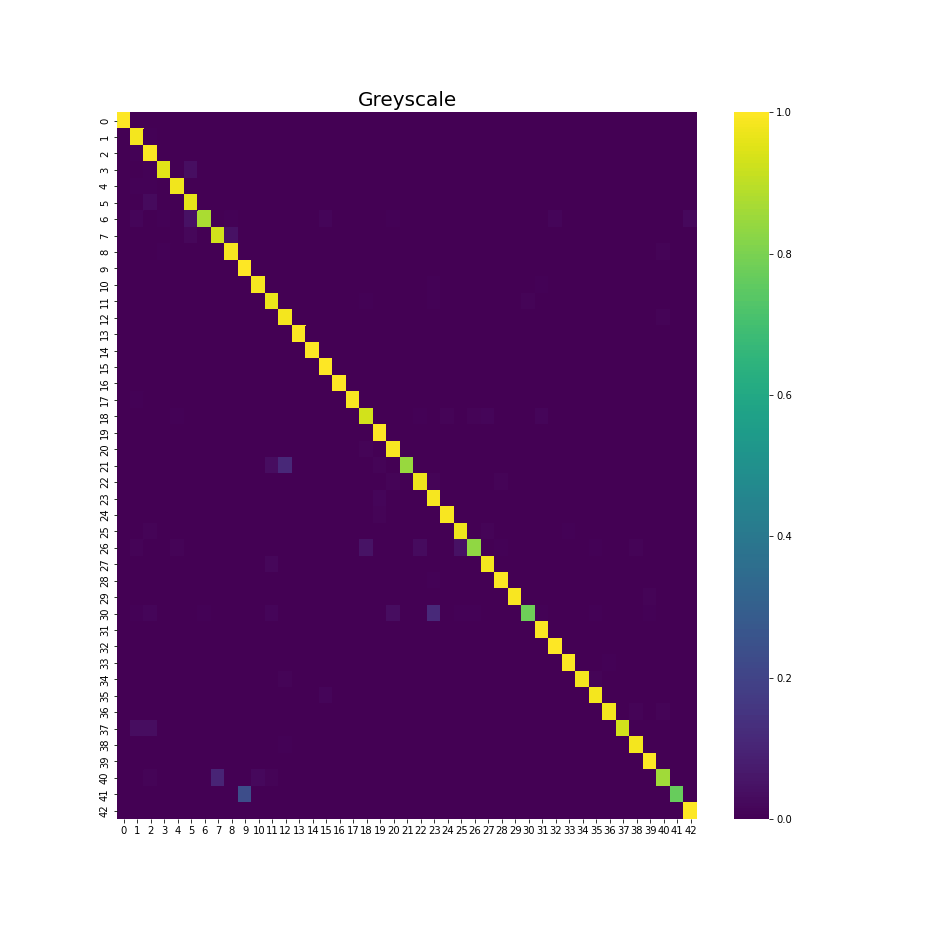

In [ ]:
plot_confusion_gif(merged_scores, 'Greyscale', ['Greyscale', 'Greyscale Augment', 'Greyscale Oversampled + Augmented'])

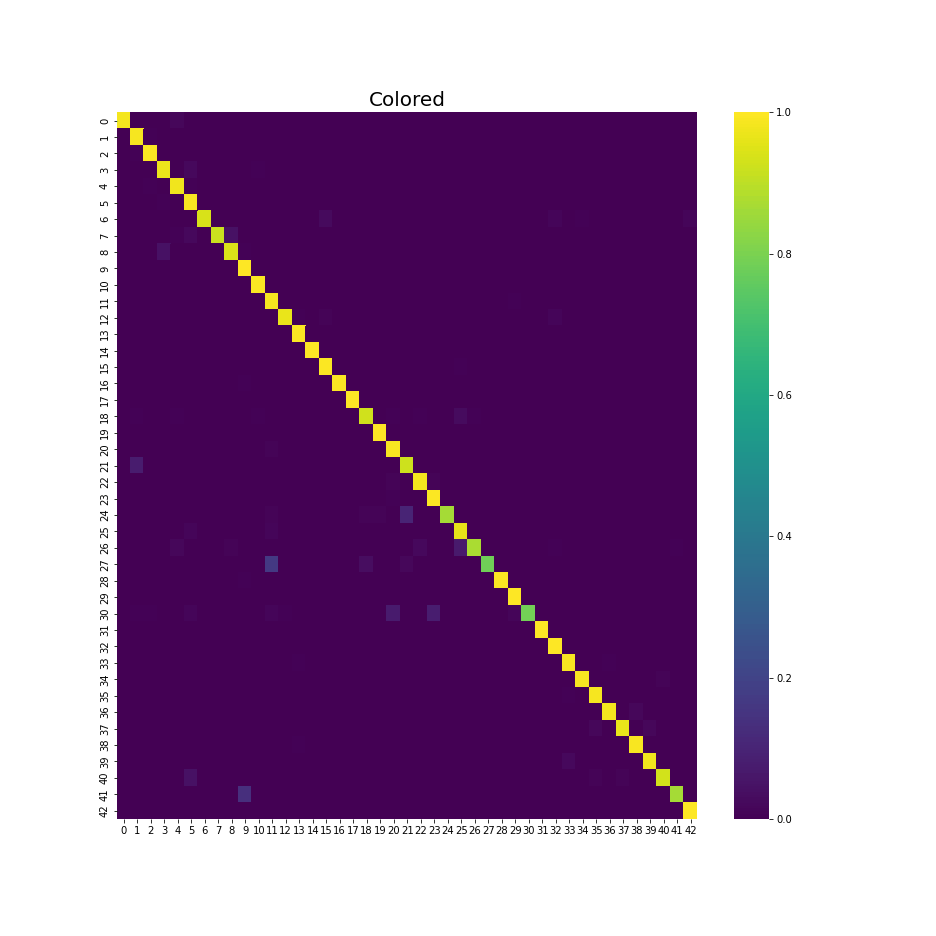

In [ ]:
plot_confusion_gif(merged_scores, 'Colored', ['Colored', 'Colored Augment', 'Colored Oversampled + Augmented'])

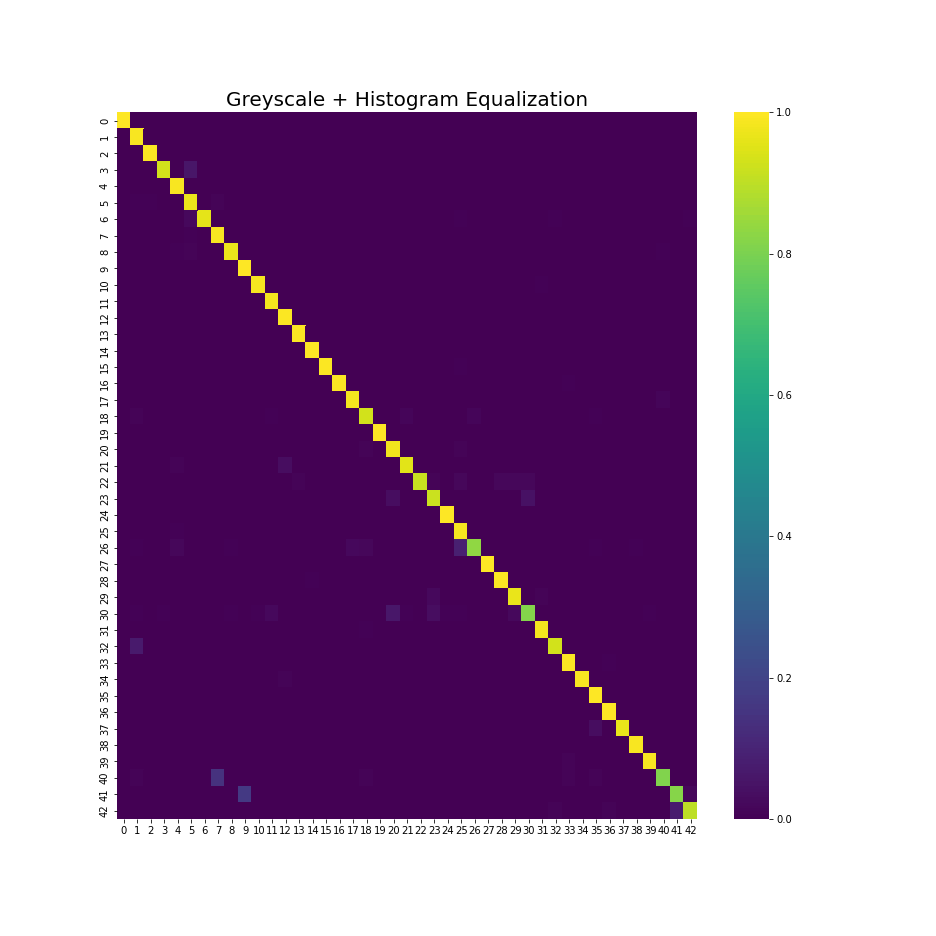

In [ ]:
plot_confusion_gif(merged_scores, 'Greyscale + Histogram Equalization', ['Greyscale + Histogram Equalization', 'Greyscale + Histogram Equalization Augment', 'Greyscale + Histogram Equalization Oversampled + Augmented'])

###4.1.4 - Hyperparameter tuning best trial using Bayesian Optimization

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=8373d4c5619789c23c65af59afff566e46d104e55a005db29a18eaa97d84621b
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, RMSprop
from keras.callbacks import EarlyStopping

In [ ]:
X_train, y_train, X_test, y_test, X_val, y_val = preprocess_images(30, 30, crop = False, greyscale = True, equalize_hist=False, oversampled = True)
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

Credit goes to the following articles for help in writing this part:

*   https://analyticsindiamag.com/neural-network-hyperparameter-tuning-using-bayesian-optimization/
*   https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/
* https://coderzcolumn.com/tutorials/machine-learning/bayes-opt-bayesian-optimization-for-hyperparameters-tuning




In [ ]:
def get_model(neurons_first_block, neurons_second_block, epochs, batch_size, optimizer, activation, dropout_rate):
  model = keras.models.Sequential([
        keras.layers.Conv2D(neurons_first_block, 3, activation=activation, padding="same",
                            input_shape=[30, 30, 1]),
        keras.layers.Conv2D(neurons_first_block, 3, activation=activation, padding="same"),
        keras.layers.MaxPooling2D(2),
        keras.layers.Conv2D(neurons_second_block, 3, activation=activation, padding="same"),
        keras.layers.Conv2D(neurons_second_block, 3, activation=activation, padding="same"),
        keras.layers.MaxPooling2D(2),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Flatten(),
        keras.layers.Dense(500, activation=activation),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(43, activation="softmax")])
  return model

In [ ]:
def fit_with(neurons_first_block, neurons_second_block, epochs, batch_size, optimizer, activation, dropout_rate):

    epochs = round(epochs)
    neurons_first_block = round(neurons_first_block)
    neurons_second_block = round(neurons_second_block)
    batch_size = round(batch_size)
    optimizerL = ['SGD', 'Adam', 'Adadelta','RMSprop']
    optimizerD= {'Adam':Adam(), 'SGD':SGD(learning_rate=0.1, decay = 1e-4), 'Adadelta':Adadelta(learning_rate=0.9), 'RMSprop': RMSprop()}
    activationL = ['relu', keras.layers.LeakyReLU()]
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    model = get_model(neurons_first_block, neurons_second_block, epochs, batch_size, optimizer, activation, dropout_rate)
    monitor = EarlyStopping(monitor='val_loss', 
        patience=5, verbose=0, mode='auto', restore_best_weights = True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.fit(X_train, y_train , epochs=round(epochs), batch_size=batch_size, validation_data = (X_val, y_val), callbacks=[monitor], verbose = 0)

    score = model.evaluate(X_test, y_test, verbose= 0)

    return score[1]

In [ ]:
params_nn ={
    'neurons_first_block': (30, 100),
    'neurons_second_block': (30, 100),
    'epochs':(30, 100),
    'batch_size':(30, 100),
    'optimizer':(0,3),
    'activation':(0, 1),
    'dropout_rate': (0.3, 0.7)
}

In [ ]:
optimizer = BayesianOptimization(
                               fit_with,
                                params_nn,
                                random_state=100
                              )
optimizer.maximize()

|   iter    |  target   | activa... | batch_... | dropou... |  epochs   | neuron... | neuron... | optimizer |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.9835   |  0.5434   |  49.49    |  0.4698   |  89.13    |  30.33    |  38.51    |  2.012    |
|  2        |  0.9842   |  0.8259   |  39.57    |  0.53     |  92.39    |  44.64    |  42.97    |  0.3251   |
|  3        |  0.9825   |  0.2197   |  98.5     |  0.6247   |  42.04    |  87.14    |  49.19    |  1.295    |
|  4        |  0.9832   |  0.94     |  87.24    |  0.4344   |  42.28    |  56.1     |  30.4     |  0.7573   |
|  5        |  0.9826   |  0.7957   |  31.07    |  0.5395   |  72.27    |  37.36    |  56.74    |  0.1094   |
|  6        |  0.9819   |  0.6859   |  43.38    |  0.4824   |  98.62    |  43.27    |  39.03    |  0.4702   |
|  7        |  0.9833   |  0.6895   |  68.44    |  0.6356   |  89.31    |  78.88    |  76.88    |  1.263    |
|  8      